In [43]:
%matplotlib inline
import gym
import numpy as np
from collections import defaultdict 
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import math
import sys, traceback
import logging
import pickle
import copy
from sklearn import linear_model
import tensorflow as tf
import pickle

In [44]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger()
Q = defaultdict(dict)
Observed_Counts = defaultdict(dict)
ALPHA = 0.1
GAMMA = 0.9
NO_OF_EPISODES = 3000
NO_OF_ITER = 500
ANGLE_TILE_SIZE = 18 # Should be such that no bin lies on both sides of center
THETADOT_TILE_SIZE = 6
# ACTIONS = [-2, -1.6, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1.6, 2]
ACTIONS = [-1.5, -0.1, 0, 0.1, 1.5 ]
MAX_LENGTH_MEMORY = 10000
REPLAY_SAMPLE_SIZE = 50
ENABLE_REPLAY = False
DEBUG = False
replay_memory = []
filename = str(NO_OF_EPISODES) + '_' + str(NO_OF_ITER) + '_' + str(MAX_LENGTH_MEMORY) + '_' + str(REPLAY_SAMPLE_SIZE)
current_session = None
IS_MODEL_INIT = False
filename = 'TF' + str(NO_OF_EPISODES) + '_' + str(NO_OF_ITER) + '_' + str(MAX_LENGTH_MEMORY) + '_' + str(REPLAY_SAMPLE_SIZE)

In [45]:
# Credits: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb
# Parameters
learning_rate = 0.001
training_epochs = 1
batch_size = 100

# Network Parameters
n_hidden_1 = 5 # 1st layer number of features
n_hidden_2 = 5 # 2nd layer number of features
n_input = 3 # State and action
n_classes = 1 # Reward

# Memory for storing rewards obtained
reward_memory = []
MIN_OBSERVE_LEN = 5000
EVALUATION_EPISODE_SIZE = NO_OF_EPISODES

In [34]:
# Code Credits: http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374
# Functions to display the constructed tensorflow graph
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [35]:
thetadot_bin = {}
def epsilon_greedy(state, epsilon):
    # print state
    valid_actions = Q[state].keys()
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    max_action = max(Q[state], key=Q[state].get)
    return max_action

def set_thetadot_bins():
    thetadot_bin[1] = (0, 0.5)
    thetadot_bin[-1] = (-0.5, 0)
    thetadot_bin[2] = (0.5, 1.5)
    thetadot_bin[3] = (1.5, 2.5)
    thetadot_bin[4] = (2.5, 3.5)
    thetadot_bin[5] = (3.5, 4.5)
    thetadot_bin[6] = (4.5, 5.5)
    thetadot_bin[7] = (5.5, 6.5)
    thetadot_bin[8] = (6.5, 8.1)
    
    thetadot_bin[-2] = (-1.5, -0.5)
    thetadot_bin[-3] = (-2.5, -1.5)
    thetadot_bin[-4] = (-3.5, -2.5)
    thetadot_bin[-5] = (-4.5, -3.5)
    thetadot_bin[-6] = (-5.5, -4.5)
    thetadot_bin[-7] = (-6.5, -5.5)
    thetadot_bin[-8] = (-8.1, -6.5)


def set_theta_bins():
    theta_bin[0] = [(0,10), (350,360)]
    theta_bin[1] = [(10,30)]
    theta_bin[2] = [(30,50)]
    theta_bin[3] = [(50,70)]
    theta_bin[4] = [(70,90)]
    theta_bin[5] = [(90,110)]
    theta_bin[6] = [(110,130)]
    theta_bin[7] = [(130,150)]
    theta_bin[8] = [(150,170)]
    theta_bin[9] = [(170,190)]
    theta_bin[10] = [(190,210)]
    theta_bin[11] = [(210,230)]
    theta_bin[12] = [(230,250)]
    theta_bin[13] = [(250,270)]
    theta_bin[14] = [(270,290)]
    theta_bin[15] = [(290,310)]
    theta_bin[16] = [(310,330)]
    theta_bin[17] = [(330,350)]    

set_thetadot_bins()

def get_theta_bin(angle):
    bin_num = int(angle/ANGLE_TILE_SIZE)
    return bin_num
    
def get_thetadot_bin(i):
    for key in thetadot_bin:
        if i > thetadot_bin[key][0] and i <= thetadot_bin[key][1]:
            return key
    raise Exception("Key not found for %s"%(i))

def get_discrete_state(S):
    theta = get_theta_bin((math.degrees(normalize_angle_360(S[0])))) 
    thetadot = get_thetadot_bin(S[1])
    return (theta, thetadot)

def normalize_angle_180(x):
    x = (x % (2*np.pi))
    if x < 0:
        x = ( x + (2*np.pi))
    if x >=0 and x <=180:
        return x
    else:
        return x - 360

def normalize_angle_360(x):
    x = (x % (2*np.pi))
    if x < 0:
        return ( x + (2*np.pi))
    return x
    
def init_Q():
    angle_incr_step = (1.8/(180/ANGLE_TILE_SIZE))
    for theta in range(0, 360/ANGLE_TILE_SIZE):
        for thetadot in thetadot_bin.keys():
            for action in ACTIONS:
                if theta > 180:
                    Q[(theta, thetadot)][action] = 0.2 + (angle_incr_step * (360 - theta))
                else:
                    Q[(theta, thetadot)][action] = -(0.2 + (angle_incr_step * (theta)))
                Observed_Counts[(theta, thetadot, action)] = 0

In [36]:
# Credits: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py
# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev', stddev)
        tf.scalar_summary('max', tf.reduce_max(var))
        tf.scalar_summary('min', tf.reduce_min(var))
        tf.histogram_summary('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.histogram_summary('pre_activations', preactivate)
        if act is not None:
            activations = act(preactivate, name='activation')
            tf.histogram_summary('activations', activations)
            return activations
        return preactivate

def build_model_graph():    
    # Linear Network
    layer1 = nn_layer(input_ph, n_input, n_hidden_1, 'L1', act=None)
    print layer1
    layer2 = nn_layer(layer1, n_hidden_1, n_hidden_2, 'L2', act=None)
    print layer2
    y_pred = nn_layer(layer2, n_hidden_2, 1, 'YPred', act=None)
    print y_pred
    
    # Loss
    y_diff = tf.sub(output_ph, y_pred, name='YDiff')
    loss = tf.reduce_sum(tf.square(y_diff), name='Loss')
    print loss
    
    # Optimizer node
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Summary node
    with tf.name_scope('Summaries'):
        # Create a summary to monitor cost tensor
        tf.scalar_summary("loss", loss)
        # Merge all summaries into a single op
        summary = tf.merge_all_summaries()
    
    return y_pred, loss, optimizer, summary

In [37]:
def update_model(optimizer, sess):
    global IS_MODEL_INIT
    if not IS_MODEL_INIT:
        IS_MODEL_INIT = True
    minibatch = random.sample(reward_memory, batch_size)
    X, y = [], []
    for reward_sample in reward_memory:
        X.append(reward_sample[:-1])
        y.append(reward_sample[-1])
    X_train = np.array(X)
    y_train = np.array(y).reshape(len(y), 1)
    sess.run(optimizer, feed_dict={input_ph:X_train, output_ph:y_train})

def predict_reward(state, output_layer, sess):
    reward = sess.run(output_layer, feed_dict={input_ph: [state]})
#     print 'State : %s, Action Predicted: %s'%(state, reward[0][0])
    return reward[0][0] 

In [38]:
def qlearning_decay(env_name, ep, sess, model, optimizer, loss, summary):
    env = gym.make(env_name)
    init_Q()
    episode_rewards = []
    observed_theta, observed_thetadot = [], []
    all_observed_theta, all_observed_thetadot = [], []
    td_error_all = []
    epsilon = ep
    current_session = None
    for i in range(NO_OF_EPISODES):
        if i % 100 == 0:
            print 'Episode %d'%(i)
        total_episode_reward = 0
        S = env.reset()
        discrete_S = get_discrete_state(S)
        for t in range(NO_OF_ITER):
            A = epsilon_greedy(discrete_S, epsilon)
            S_next, reward, _, _ = env.step([A])
            if reward == 0: # Did not receive the reward for this time step.
                if len(reward_memory) < int(MIN_OBSERVE_LEN) or not IS_MODEL_INIT: # Check what should be done here ?
                    continue
                reward = predict_reward(np.array([S[0], S[1], A]), model, sess)
            else:
                reward_memory.append(np.array([S[0], S[1], A, reward]))
            total_episode_reward += reward
            discrete_S_next = get_discrete_state(S_next)
            A_next = max(Q[discrete_S_next], key=Q[discrete_S_next].get)
            # Update the Q values
            td_error = reward + GAMMA*Q[discrete_S_next][A_next] - Q[discrete_S][A]
            td_error_all.append(td_error**2)
            Q[discrete_S][A] = Q[discrete_S][A] + ALPHA*(td_error)
            discrete_S = discrete_S_next
        episode_rewards.append(total_episode_reward)
        if len(reward_memory) >= int(MIN_OBSERVE_LEN):
            update_model(optimizer, sess)
        if i > 1000:
            epsilon -= (1/i)
    print 'Observed rewards in %d steps out of %d steps'%(len(reward_memory), (NO_OF_EPISODES*NO_OF_ITER))
    return episode_rewards, td_error_all

In [39]:
def smooth_graph(yvalues):
    smooth_values = []
    for i in range(len(yvalues) - 100):
        l = yvalues[i:i+100]
        smooth_values.append(sum(l) / 100)
    return smooth_values

# ADD PICKLE DUMPS
def evaluation(env_name, q_filename):
    Q = pickle.load( open(q_filename, "rb" ) )
    env = gym.make(env_name)
    episode_rewards = []
    for i in range(EVALUATION_EPISODE_SIZE):
        S = env.reset()
        episode_reward = 0
        for t in range(NO_OF_ITER):
            dis_S = get_discrete_state(S)
            max_action = max(Q[dis_S], key=Q[dis_S].get)
            S, reward, _, _ = env.step([max_action])
            episode_reward += reward
        episode_rewards.append(episode_reward)
    return episode_rewards

In [40]:
env_name = 'SemisuperPendulumRandom-v0'
tf.reset_default_graph()
# tf Graph input
input_ph = tf.placeholder(tf.float32, [None, n_input], name='X')
# tf Graph Output
output_ph = tf.placeholder(tf.float32, [None, n_classes])
with tf.Session() as sess:
    model, optimizer, loss, summary = build_model_graph()
    init_vars = tf.initialize_all_variables()
    sess.run(init_vars)
#     show_graph(tf.get_default_graph().as_graph_def())
    episode_rewards, td_error_all = qlearning_decay(env_name, 0.2, sess, model, optimizer, loss, summary)
    pickle.dump(Q, open('pickle_dumps/' + filename + '_' + env_name, "wb"))
#     eval_rewards = evaluation(env_name, sess,model)

Tensor("L1/Wx_plus_b/add:0", shape=(?, 5), dtype=float32)
Tensor("L2/Wx_plus_b/add:0", shape=(?, 5), dtype=float32)
Tensor("YPred/Wx_plus_b/add:0", shape=(?, 1), dtype=float32)
Tensor("Loss:0", shape=(), dtype=float32)


[2016-11-26 15:44:18,324] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Observed rewards in 100383 steps out of 1000000 steps


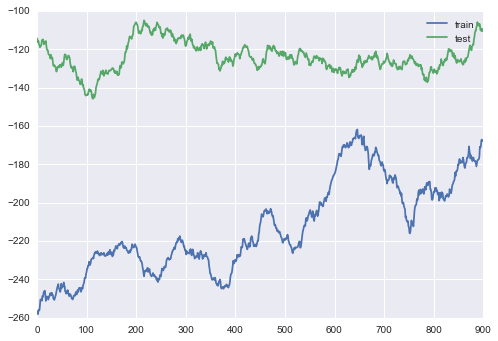

In [20]:
plt.plot(smooth_graph(episode_rewards))
plt.plot(smooth_graph(eval_rewards))
plt.legend(['train', 'test'])

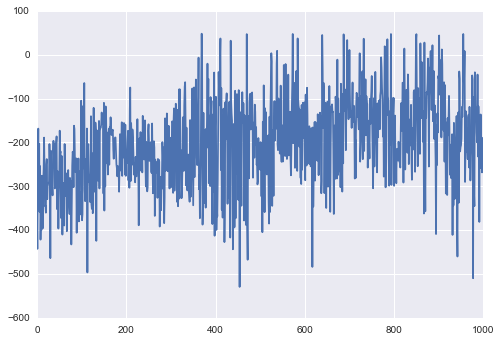

In [12]:
plt.plot(episode_rewards)

In [21]:
def render(env_name):
    env = gym.make(env_name)
    S = env.reset()
    env.render()
    for t in range(NO_OF_ITER):
        dis_S = get_discrete_state(S)
        max_action = max(Q[dis_S], key=Q[dis_S].get)
        S, reward, _, _ = env.step([max_action])
        env.render()
render('SemisuperPendulumRandom-v0')

[2016-11-26 15:16:36,451] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)


In [ ]:
qfiles = ['pickle_dumps/Q2000_500_10000_50_Pendulum-v0.p', 'pickle_dumps/TF2000_500_10000_50_SemisuperPendulumRandom-v0']
legend = ['Supervised', 'SSRandom']
all_rewards = []
for q in qfiles:
    rewards = evaluation('Pendulum-v0', q)
    all_rewards.append(rewards)
 

[2016-11-26 16:01:42,573] Making new env: Pendulum-v0


Action Space
Box(1,)
Observation Space
Box(3,)


[2016-11-26 16:03:01,517] Making new env: Pendulum-v0


Action Space
Box(1,)
Observation Space
Box(3,)


In [ ]:
print len(all_rewards)
for p in all_rewards:
    plt.plot(smooth_graph(p))
plt.legend(legend)